# Weight Initialization

Example how to find good initial weights for a neural network. Weight initialization happens once, when a model is created and before it trains. Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker.

### Dataset and Model
We'll train an MLP to classify images from the Fashion-MNIST database to demonstrate the effect of different initial weights. As a reminder, the FashionMNIST dataset contains images of clothing types; classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']. The images are normalized so that their pixel values are in a range [0.0 - 1.0).

## Import Libraries

In [7]:
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch

import matplotlib.pyplot as plt
%matplotlib inline

## Load the Data

In [8]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  60000
Num test images:  10000


In [9]:
# specify the image classes
classes = ['T-shirt/top', 
           'Trouser', 
           'Pullover', 
           'Dress', 
           'Coat', 
           'Sandal', 
           'Shirt', 
           'Sneaker', 
           'Bag', 
           'Ankle boot']

## Set the Data Loaders

In [10]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

## Visualise Some Training Data

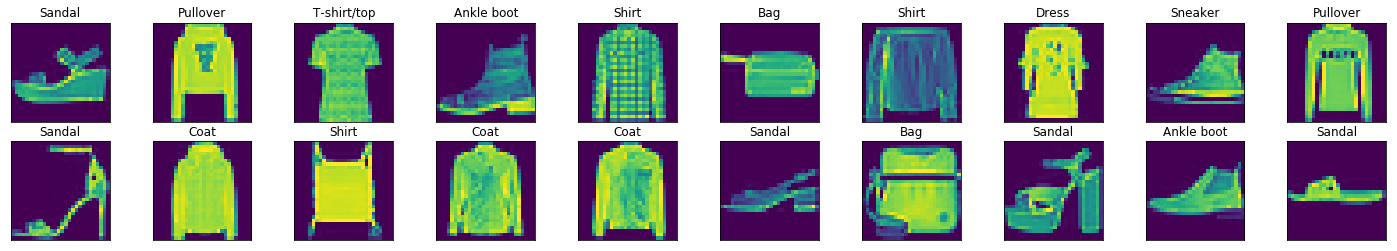

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(classes[labels[idx]])

## Compare Initialised Weights

### Automatic Weight Initialisation
Using default weights

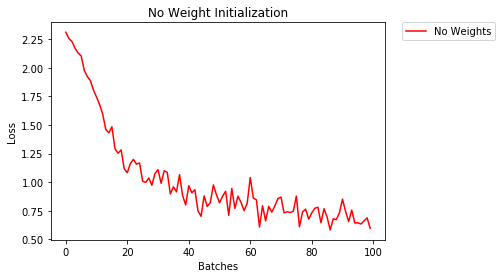

After 2 Epochs:
Validation Accuracy
   85.708% -- No Weights
Training Loss
    0.330  -- No Weights


In [13]:
import helpers
import model

model_no_initialization = model.Net()

model_list = [(model_no_initialization, 'Default Weights')]

# evaluate behavior 
helpers.compare_init_weights(model_list, 
                             'Default Weight Initialization', 
                             train_loader,
                             valid_loader)

### Uniform Initialisation
Train using a uniform weight initialization, low=0.0 and high=1.0

In [14]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

In [16]:
# create a new model with these weights
model_uniform = model.Net()
model_uniform.apply(weights_init_uniform)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

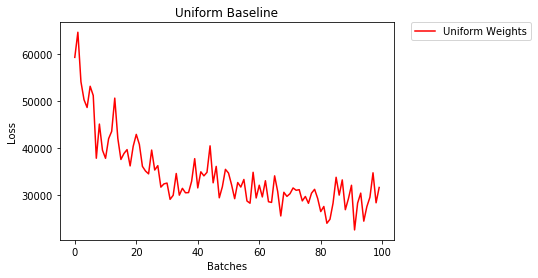

After 2 Epochs:
Validation Accuracy
   32.125% -- Uniform Weights
Training Loss
    4.456  -- Uniform Weights


In [17]:
# evaluate behavior 
helpers.compare_init_weights([(model_uniform, 'Uniform Weights')], 
                             'Uniform Baseline', 
                             train_loader,
                             valid_loader)

### Centered Distribution
Create 2 models:

Centered model; weight initialization [-0.5, 0.5]

General rule model; weight initialization using the range $[-y, y]$, where $y=1/\sqrt{n}$ .

In [18]:
# takes in a centered module and applies the specified weight initialization
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a centered, uniform distribution to the weights
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)

# create a new model with these weights
model_centered = model.Net()
model_centered.apply(weights_init_uniform_center)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [19]:
# takes in a uniform rule module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model_rule = model.Net()
model_rule.apply(weights_init_uniform_rule)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

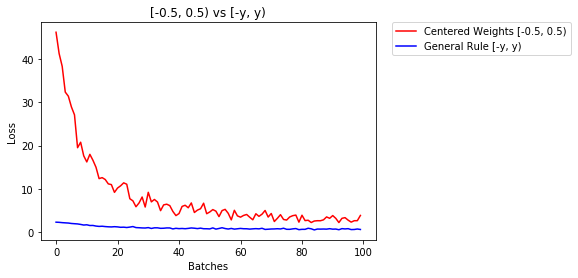

After 2 Epochs:
Validation Accuracy
   76.650% -- Centered Weights [-0.5, 0.5)
   84.667% -- General Rule [-y, y)
Training Loss
    0.703  -- Centered Weights [-0.5, 0.5)
    0.383  -- General Rule [-y, y)


In [20]:
# compare these two models
model_list = [(model_centered, 'Centered Weights [-0.5, 0.5)'), 
              (model_rule, 'Uniform Rule [-y, y)')]

# evaluate behavior 
helpers.compare_init_weights(model_list, 
                             '[-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)

### Normal Distribution
Define a normal distribution that has a mean of 0 and a standard deviation of $y=1/\sqrt{n}$ and compare against the general rule.

In [21]:
# takes in a normal distribution module and applies the specified weight initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

In [22]:
# create a new model with the rule-based, uniform weights
model_uniform_rule = model.Net()
model_uniform_rule.apply(weights_init_uniform_rule)

# create a new model with the rule-based, NORMAL weights
model_normal_rule = model.Net()
model_normal_rule.apply(weights_init_normal)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

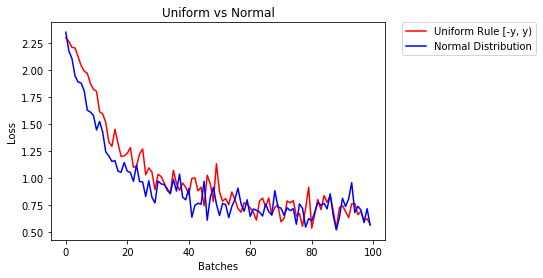

After 2 Epochs:
Validation Accuracy
   85.417% -- Uniform Rule [-y, y)
   84.992% -- Normal Distribution
Training Loss
    0.255  -- Uniform Rule [-y, y)
    0.434  -- Normal Distribution


In [23]:
# compare the two models
model_list = [(model_uniform_rule, 'Uniform Rule [-y, y)'), 
              (model_normal_rule, 'Normal Distribution')]

# evaluate behavior 
helpers.compare_init_weights(model_list, 
                             'Uniform vs Normal', 
                             train_loader,
                             valid_loader)

The automatic weight initiaisation had the best accuracy, although the uniform rule was only 0.1% different. The uniform rule had a much better training loss so we should use those weights on this model.